In [66]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from einops.layers.torch import Rearrange
from einops import rearrange
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
from tqdm import tqdm

## Model Configurations

Each MixerBlock has a 2 layer MLP with a hiddenDim = 128 \
number of mixer blocks = 4 (shallow depth) \
Embedding Dimension = 256 \
Patch dimension = 14 \
number of patches per image = 4

In [77]:
class MLP(nn.Module):
    def __init__(self, dim, hiddenDim):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(dim, hiddenDim),
            nn.GELU(), # as specified in the paper
            nn.Linear(hiddenDim, dim)
        )

    def forward(self, x):
        x = self.model(x)
        return x

# create the mixer block architecture
class MixerBlock(nn.Module):
    def __init__(self, embeddingDim=256, patchesCount=4, hiddenDim=128):
        super().__init__()

        self.firstNorm = nn.LayerNorm(embeddingDim)
        self.secondNorm = nn.LayerNorm(embeddingDim)
        
        self.tokenBlock = MLP(patchesCount, hiddenDim)
        self.channelBlock = MLP(embeddingDim, hiddenDim)

    def forward(self, x):
        y = self.firstNorm(x)
        y = rearrange(x, 'a b c -> a c b') # transpose the batch
        y = self.tokenBlock(y) # run the token block
        y = rearrange(y, 'a b c -> a c b') # transpose the batch
        res = y + x # residual connections
        y = self.secondNorm(res) # layer norm
        y = self.channelBlock(y) # run the channel block
        y = y + res # residual connections
        return y


class MLPMixer(nn.Module):
    def __init__(self, imageSize=28, patchSize=14, channels=1, embeddingDim=256, mixerLayers=4, hiddenDim=128, outputDim=10):
        """ Model initalizer """
        super().__init__()
        
        if imageSize % patchSize != 0:
            raise Exception("irregular patch size. Patch size must be a factor of Image size")

        patchesCount = int (2 * imageSize/patchSize)
        patchDim = patchSize*patchSize*channels

        self.generateEmbeddings = nn.Sequential(
            # rearrange into patches
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patchSize, p2=patchSize),
            nn.Linear(patchDim, embeddingDim)
        )

        #add mixer blocks
        self.blocks = nn.Sequential(
            *[nn.Sequential(
                MixerBlock(
                    embeddingDim,
                    patchesCount,
                    hiddenDim
                )
            )
              for _ in range(mixerLayers)]
        )

        # add classifier
        self.classifier = nn.Linear(embeddingDim, outputDim)
        
    def forward(self, x):
        x = self.generateEmbeddings(x)
        x = self.blocks(x)

        #global average pool
        x = x.mean(dim=1)
        return self.classifier(x)

In [78]:
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

In [79]:
img_shape = train_dataset[0][0].shape
label = train_dataset[0][1]

print(f"Image shape: {img_shape}")
print(f"Label: {label}")

Image shape: torch.Size([1, 28, 28])
Label: 9


In [87]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [88]:
imgs, labels = next(iter(eval_loader))
print(f"{imgs.shape = }")
print(f"{labels.shape = }")

imgs.shape = torch.Size([64, 1, 28, 28])
labels.shape = torch.Size([64])


In [89]:
rearrange(imgs, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=14, p2=14).shape

torch.Size([64, 4, 196])

In [90]:
def train_nn(model, train_loader, criterion, optimizer, device):
    """Function to train the neural network for one epoch"""
    model.train()
    running_loss = 0.0
    correct_labels = 0
    total_labels = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted_labels = torch.argmax(outputs, dim=1)
        total_labels += labels.size(0)
        correct_labels += torch.sum(predicted_labels == labels).item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_labels / total_labels
    
    return train_loss, train_accuracy



In [91]:
def evaluate_nn(model, test_loader, criterion, device):
    """
    Function to evaluate the neural network on the test data.
    """
    model.eval()
    running_loss = 0.0
    correct_labels = 0
    total_labels = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            predicted_labels = torch.argmax(outputs, dim=1)
            total_labels += labels.size(0)
            correct_labels += torch.sum(predicted_labels == labels).item()

    test_loss = running_loss / len(test_loader)
    test_accuracy = correct_labels / total_labels
    return test_loss, test_accuracy

In [92]:
def run_training(hidden_dim, lr, num_epochs):
    """
    Function to train and evaluate the model for a given number of epochs.
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MLPMixer().to(device)                    # Initialize model
    criterion = nn.CrossEntropyLoss()                           # Loss function
    optimizer = optim.Adam(model.parameters(), lr=lr)            # Optimizer

    train_losses = []
    test_losses = []
    
    train_accuracies = []
    test_accuracies = []

    # Training loop
    for epoch in tqdm(range(num_epochs)):
        train_loss, train_accuracy = train_nn(model, train_loader, criterion, optimizer, device)
        test_loss, test_accuracy = evaluate_nn(model, test_loader, criterion, device)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
        print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}")

    # Returns the model metrics.
    return model, train_losses, train_accuracies, test_losses, test_accuracies

### NOTE: model accuracy starts to decrease after 8 epochs

In [103]:
hidden_dim = 128
lr = 0.001
num_epochs = 8

# Call the model training function
model, train_losses, train_accuracies, test_losses, test_accuracies = run_training(hidden_dim, lr, num_epochs)

 12%|██████████▌                                                                         | 1/8 [00:25<02:57, 25.39s/it]

Epoch 1/8
Train Loss: 0.4698, Train Acc: 0.8275
Test Loss: 0.4001, Test Acc: 0.8499


 25%|█████████████████████                                                               | 2/8 [00:50<02:30, 25.02s/it]

Epoch 2/8
Train Loss: 0.3536, Train Acc: 0.8694
Test Loss: 0.3548, Test Acc: 0.8686


 38%|███████████████████████████████▌                                                    | 3/8 [01:15<02:06, 25.33s/it]

Epoch 3/8
Train Loss: 0.3136, Train Acc: 0.8828
Test Loss: 0.3440, Test Acc: 0.8721


 50%|██████████████████████████████████████████                                          | 4/8 [01:41<01:42, 25.62s/it]

Epoch 4/8
Train Loss: 0.2849, Train Acc: 0.8937
Test Loss: 0.3362, Test Acc: 0.8771


 62%|████████████████████████████████████████████████████▌                               | 5/8 [02:06<01:16, 25.37s/it]

Epoch 5/8
Train Loss: 0.2609, Train Acc: 0.9039
Test Loss: 0.3560, Test Acc: 0.8713


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [02:31<00:50, 25.15s/it]

Epoch 6/8
Train Loss: 0.2388, Train Acc: 0.9100
Test Loss: 0.3350, Test Acc: 0.8799


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [02:56<00:25, 25.11s/it]

Epoch 7/8
Train Loss: 0.2185, Train Acc: 0.9173
Test Loss: 0.3434, Test Acc: 0.8815


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [03:21<00:00, 25.21s/it]

Epoch 8/8
Train Loss: 0.2010, Train Acc: 0.9232
Test Loss: 0.3279, Test Acc: 0.8869


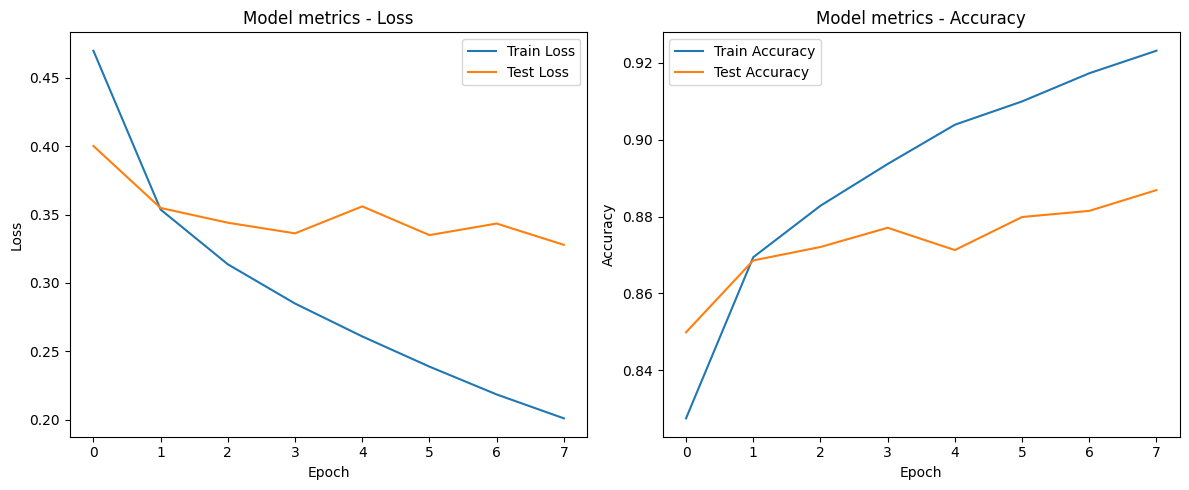

In [104]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model metrics - Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model metrics - Accuracy')
plt.tight_layout()
plt.show()

In [106]:
# Function to get predictions and true labels
def get_predictions(model, loader, device):
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = torch.argmax(outputs, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_predictions), np.array(all_labels)

# Get predictions
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
y_pred, y_true = get_predictions(model, test_loader, device)

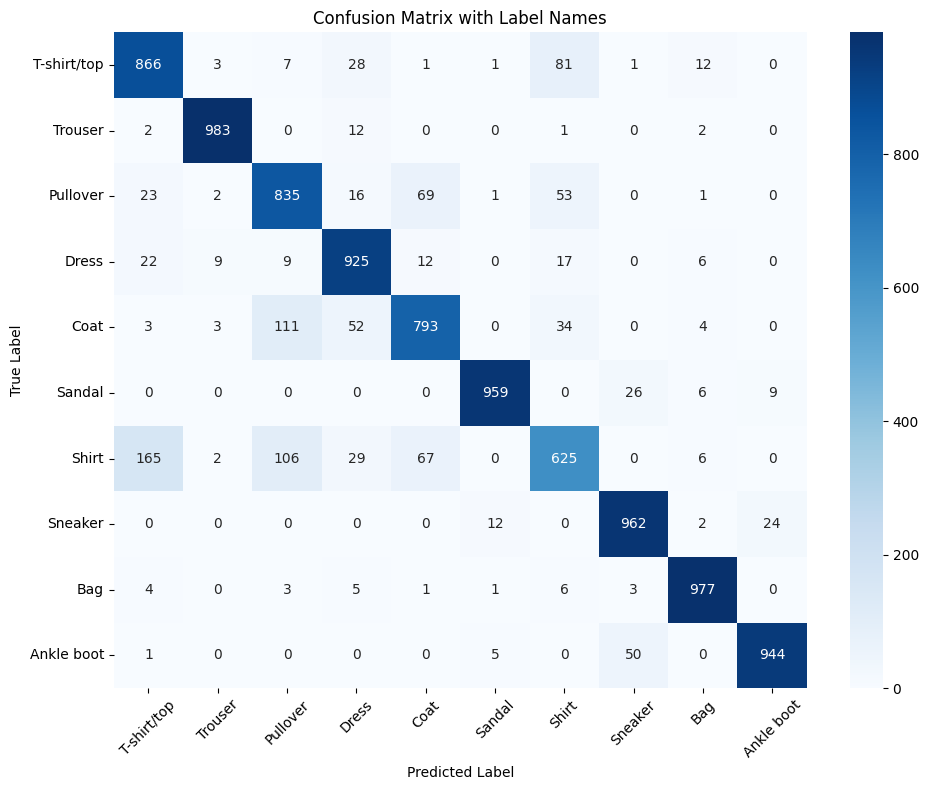

In [107]:
label_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix with Label Names')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## MLPMixer performs better than the other implementation

The model performs better even without any optimum parameter search.

## Possible Reasons:

The model mimics the VisionTransformer architecture that tries to capture as much information as possible by splitting the image into various patches and learns local features better than the simple MLP based model.